### 이미지 벡터 검색 시나리오
1. 라이브러리 로딩 및 DB 접속
2. 임베딩 모델 확인
3. 테이블 저장된 이미지 확인
4. 벡터 컬럼 초기화 및 임베딩 저장
5. 검증(입력)용 데이터 확인
6. 유사 이미지 검색(이미지 to 이미지
7. 유사 이미지 검색(텍스트 to 이미지)

#### 1.파이썬 라이브러리 로딩 및 DB 접속

In [16]:
# 23ai 접속 및 라이브러리 로딩
import oracledb
import oml
import pandas as pd
import import_ipynb
from IPython.display import display
from user_functions import get_conn_cursor, get_db_version, exec_sql,exec_sql_rows, dml_sql, ddl_sql, img_show

import os, io
from PIL import Image
import matplotlib.pyplot as plt
import math

#print("Complete load libries")

# DB 접속
conn, cursor = get_conn_cursor("vector","vector","localhost:1521/freepdb1")

# DB 버전 확인
get_db_version(cursor)

,PRODUCT,VERSION_FULL
0,Oracle Database 23ai Free,23.8.0.25.04


#### 2. 임베딩 모델 확인
- VIT_BASE_PATCH16_224_IMG 모델은 openai/clip-vit-large-patch14 CLIP 멀티모달 모델을 ONNX로 전환하여 DB에 저장된 모델임

In [17]:
# DB관리중인 ONNX 모델 조회
managed_models = 'SELECT MODEL_NAME, MINING_FUNCTION, ALGORITHM, ALGORITHM_TYPE, (MODEL_SIZE/1024/1024) MB FROM user_mining_models ORDER BY MODEL_NAME'
print("DB관리중인 ONNX 모델")
exec_sql(cursor,managed_models)

DB관리중인 ONNX 모델


,MODEL_NAME,MINING_FUNCTION,ALGORITHM,ALGORITHM_TYPE,MB
0,MULTILINGUAL_E5_SMALL,EMBEDDING,ONNX,NATIVE,117.378383
1,PARAPHRASE_MULTILINGUAL_MPNET_BASE_V2,EMBEDDING,ONNX,NATIVE,270.086040
2,VIT_BASE_PATCH16_224,EMBEDDING,ONNX,NATIVE,327.618084
3,VIT_BASE_PATCH16_224_IMG,EMBEDDING,ONNX,NATIVE,292.181850
4,VIT_BASE_PATCH16_224_TXT,EMBEDDING,ONNX,NATIVE,119.933461


#### 3. 테이블의 이미지 파일 확인

테이블 이미지 정보


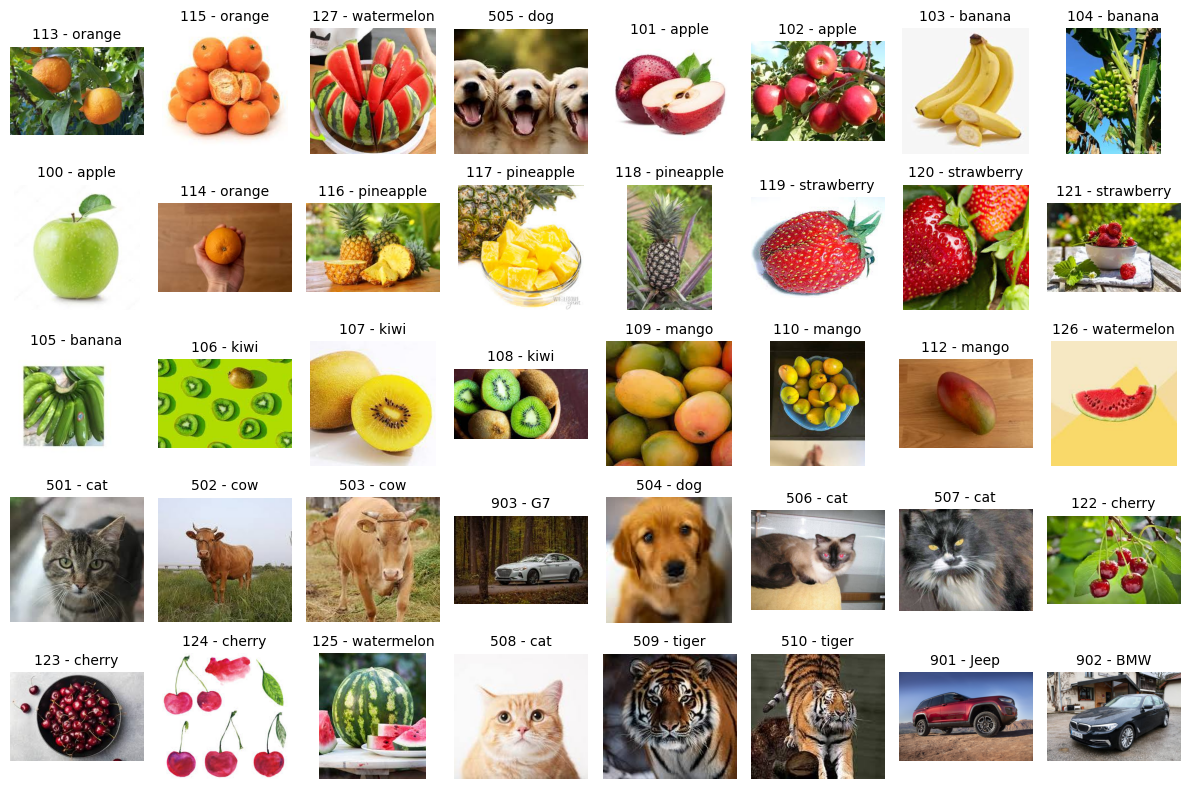

In [18]:
# 이미지 데이터 조회
img_info = """SELECT imgno, img_category_detail, img FROM img_tbl"""
rows = exec_sql_rows(cursor,img_info)

images = []
titles = []

for imgno, category, blob in rows:
    if blob:
        try:
            img_bytes = blob.read()
            img = Image.open(io.BytesIO(img_bytes))
            images.append(img)
            titles.append(f"{imgno} - {category}")
        except Exception as e:
            print(f"IMGNO {imgno} 오류: {e}")
    else:
        print(f"IMGNO {imgno}는 이미지가 없습니다.")

# 8x5 그리드 디스플레이

print("테이블 이미지 정보")
fig, axes = plt.subplots(5, 8, figsize=(12,8))

for i in range(40):
    ax = axes[i // 8, i % 8]
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(titles[i], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

#### 4.벡터 컬럼 초기화 및 임베딩 저장 

In [19]:
# 임베딩 데이터 초기화
clean_v = """update img_tbl set img_v = NULL"""
dml_sql(conn,cursor,clean_v)
img_info = """select imgno, img_v from img_tbl fetch first 5 rows only"""
print(" 이미지 정보")
exec_sql(cursor,img_info)

 이미지 정보


,IMGNO,IMG_V
0,113,None
1,115,None
2,127,None
3,505,None
4,101,None


In [20]:
# 데이터 임베딩
# convert to vector using 벡터 험수(vector_embedding)
# 이미지 임베딩 모델 : VIT_BASE_PATCH16_224

print("임베딩 처리 & 데이터 저장중입니다.....")

img_q = """select imgno,
           vector_embedding(VIT_BASE_PATCH16_224_IMG using to_blob(img) as DATA) 
           from img_tbl order by imgno
        """
imgnos = exec_sql_rows(cursor,img_q)

# 이미지 별로 벡터 임베딩 데이터를 벡터 컬럼값으로 저장 
for row in imgnos:
    imgno = row[0]
    embedding = row[1]
    # UPDATE 쿼리 실행 
    cursor.execute("""
        UPDATE img_tbl
        SET img_v = :embedding
        WHERE imgno = :1
    """, [embedding,imgno])
    #print(f"imgno {imgno} updated.")
conn.commit()
print("embedding & saving complete!")

임베딩 처리 & 데이터 저장중입니다.....
embedding & saving complete!


#### 5.검증(입력)용 데이터 확인

테스트용 샘플 이미지


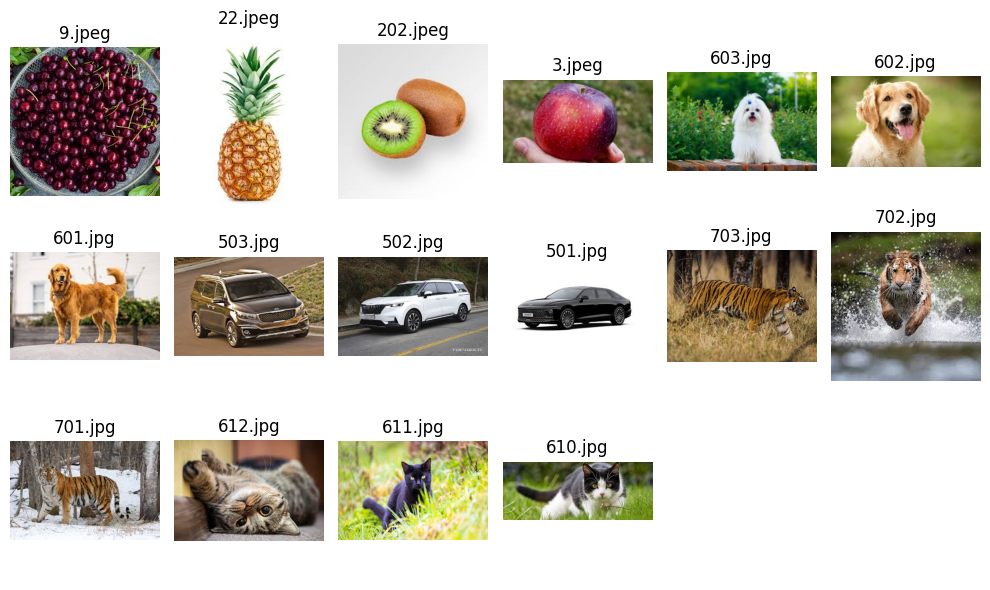

In [21]:
# 디렉토리의 이미지 확인
import os
from PIL import Image
import matplotlib.pyplot as plt
import math

# 이미지가 있는 디렉토리 경로 

print("테스트용 샘플 이미지")
img_dir = "./data/images/val_data"  
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

cols = 6
rows = math.ceil(len(img_files) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(10, 2 * rows))

for i, ax in enumerate(axes.flat):
    if i < len(img_files):
        img_path = os.path.join(img_dir, img_files[i])
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(img_files[i], fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()


#### 6. 유사 이미지 검색(이미지 to 이미지)

입력 이미지 파일명 입력 : 9.jpeg


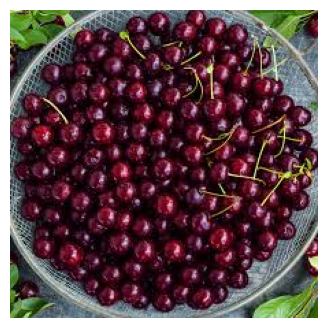

벡터 검색 결과


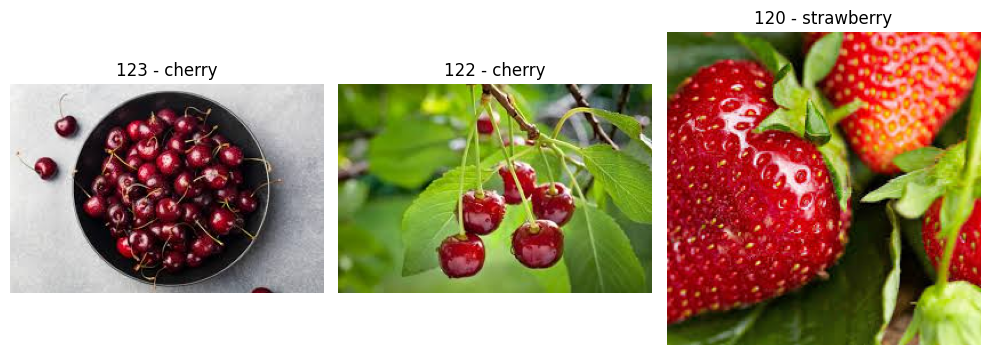

In [26]:
import oml, os
from PIL import Image
import matplotlib.pyplot as plt
from oracledb import DB_TYPE_BLOB

img_dir = "./data/images/val_data/"  
img_file = input("입력 이미지 파일명 입력 :")
img_path = os.path.join(img_dir, img_file)

# 입력 이미지 화면 표시
img_show(img_path)

# 입력 이미지 임베딩
with open(img_path, 'rb') as f:
    img = f.read()  
blob = cursor.var(DB_TYPE_BLOB)
blob.setvalue(0, img)

data = cursor.execute("select vector_embedding(VIT_BASE_PATCH16_224_IMG using :1 as DATA) from dual", [blob])
img_embed = data.fetchone()

# 테이블 이미지에서 입력 이미지와 유사한 이미지 검색(벡터 검색)

# 이미지 벡터 쿼리
img_vq = """
select imgno,img_category_detail, img from img_tbl
order by vector_distance(img_v, :1,cosine)
fetch first 3 rows only
"""
result = exec_sql_rows(cursor,img_vq,img_embed)

# 이미지 벡터 검색 결과 출력

r_images = []
r_titles = []

for imgno, category, blob in result:
    if blob:
        try:
            img_bytes = blob.read()
            img = Image.open(io.BytesIO(img_bytes))
            r_images.append(img)
            r_titles.append(f"{imgno} - {category}")
        except Exception as e:
            print(f"IMGNO {imgno} 오류: {e}")
    else:
        print(f"IMGNO {imgno}는 이미지가 없습니다.")

# 1*3 그리드 디스플레이
print("벡터 검색 결과")

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for i in range(3):
    ax = axes[i]
    if i < len(r_images):
        ax.imshow(r_images[i])
        ax.set_title(r_titles[i], fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

#### 7. 유사 이미지 검색(텍스트 to 이미지)
- 텍스트를 입력하면 의미를 입력하여 입력 텍스트와 유사한 이미지를 검색합니다

찾고 싶은 이미지 입력 : apple


벡터 검색 결과


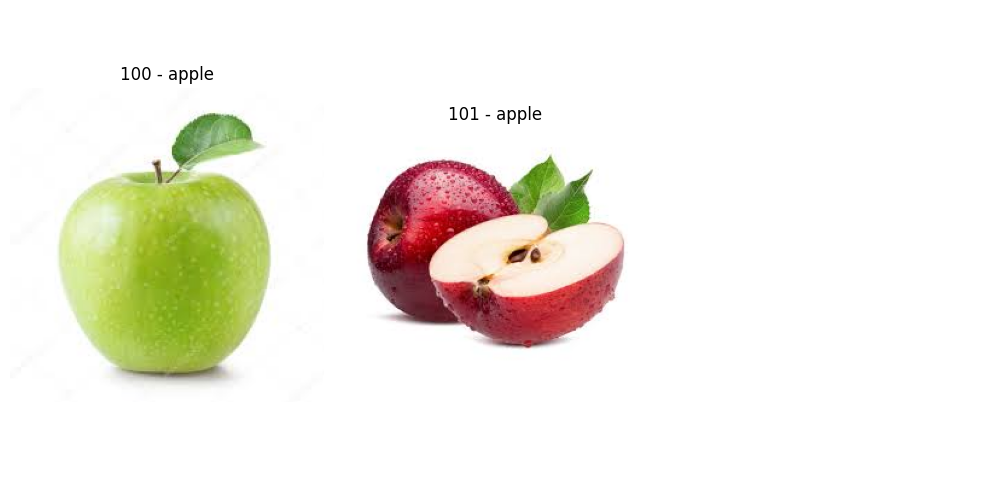

In [27]:
import oml, os
from PIL import Image
import matplotlib.pyplot as plt
from oracledb import DB_TYPE_BLOB

txt2img = input("찾고 싶은 이미지 입력 :")  #예 : cutted fruits

data = cursor.execute("select vector_embedding(VIT_BASE_PATCH16_224_TXT using :1 as DATA) from dual", [txt2img])
img_embed = data.fetchone()

# 테이블 이미지에서 입력 입력 텍스트와 의미가 유사한 이미지 검색(벡터 검색)

# 텍스트 이미지 벡터 쿼리
img_vq = """
select imgno,img_category_detail, img from img_tbl
order by vector_distance(img_v, :1,cosine)
fetch first 2 rows only
"""
result = exec_sql_rows(cursor,img_vq,img_embed)

# 텍스트 이미지 벡터 검색 결과 출력

r_images = []
r_titles = []

for imgno, category, blob in result:
    if blob:
        try:
            img_bytes = blob.read()
            img = Image.open(io.BytesIO(img_bytes))
            r_images.append(img)
            r_titles.append(f"{imgno} - {category}")
        except Exception as e:
            print(f"IMGNO {imgno} 오류: {e}")
    else:
        print(f"IMGNO {imgno}는 이미지가 없습니다.")

# 1*3 그리드 디스플레이
print("벡터 검색 결과")

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for i in range(3):
    ax = axes[i]
    if i < len(r_images):
        ax.imshow(r_images[i])
        ax.set_title(r_titles[i], fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

---------------------
이미지 벡터 검색. 끝.